In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Time Series Analysis

For diseases that occur in cyclic or repeating patterns, time series models have been used to predict future outbreaks. Traditionally, time series predictions are performed using the autoregressive integrated moving average (ARIMA) models, which attempt to filter out high-frequency noise in the data to detect local trends based on linear dependence in observations in the series. 

These models have two distinct advantages:

1. First, they can be easily interpreted in retrospective studies. Like ordinary least-square regressions the relationship between the independent variables and the dependent variables are easily understood based on the assumptions of the model. This allows a user to understand not only the relationship between the current state as a function of the past states, commonly referred to as endogenous variables, but also the influence of inputs outside the state of the series, also called exogenous variables. 

2. The second advantage of ARIMA models is that model selection can be performed over a time series in an automated fashion to maximize prediction accuracy.

In [2]:
df = pd.read_pickle('df.pkl')

In [3]:
df.head()

,total_specimens,percent_positive,_weighted_ili,ilitotal,total_patients,goog
2006-10-07,306,7.18954,1.31950,557,55212,3.250000
2006-10-14,351,6.83761,1.42022,642,53681,3.250000
2006-10-21,363,6.61157,1.38602,639,58705,3.250000
2006-10-28,305,4.59016,1.23840,651,63750,3.250000
2006-11-04,343,3.79009,1.51518,801,62203,9.416667


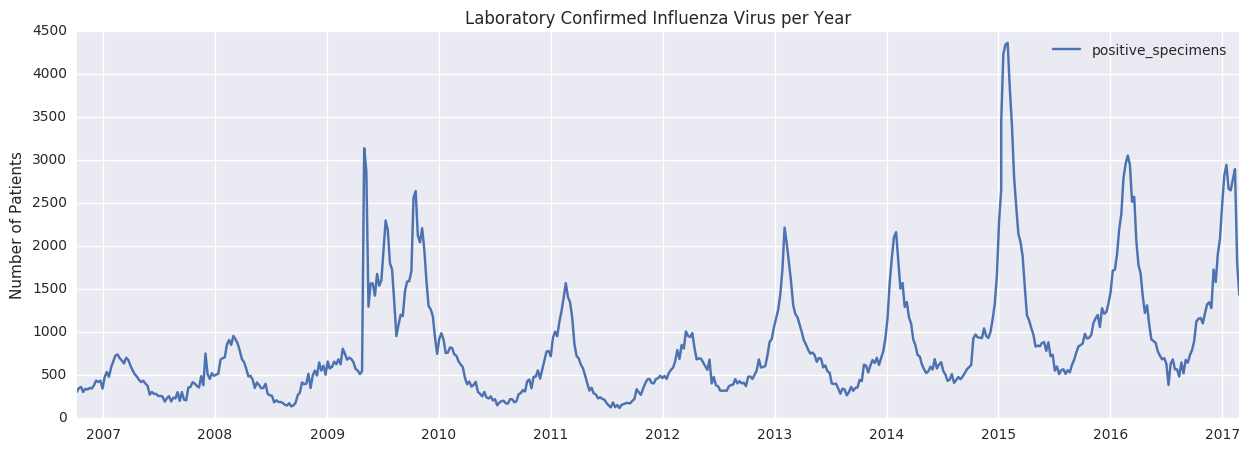

In [4]:
plt.figure(figsize=(15,5))
plt.ylabel('Number of Patients')
plt.title('Laboratory Confirmed Influenza Virus per Year')
x = plt.plot(df.index, df['total_specimens'])
plt.legend(['positive_specimens'])
plt.show()

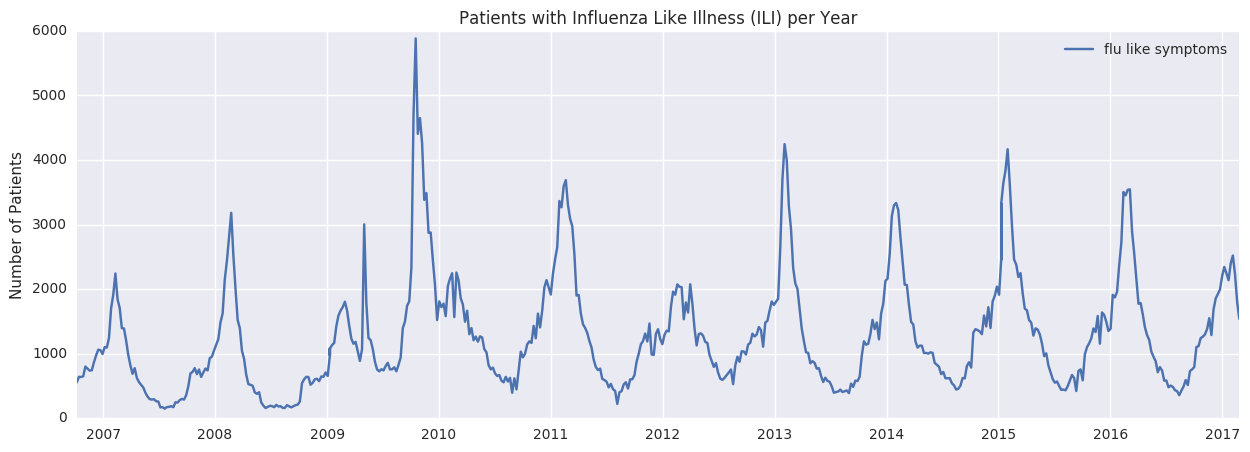

In [5]:
plt.figure(figsize=(15,5))
plt.ylabel('Number of Patients')
plt.title('Patients with Influenza Like Illness (ILI) per Year')
x = plt.plot(df.index, df['ilitotal'])
plt.legend(['flu like symptoms'])
plt.show()

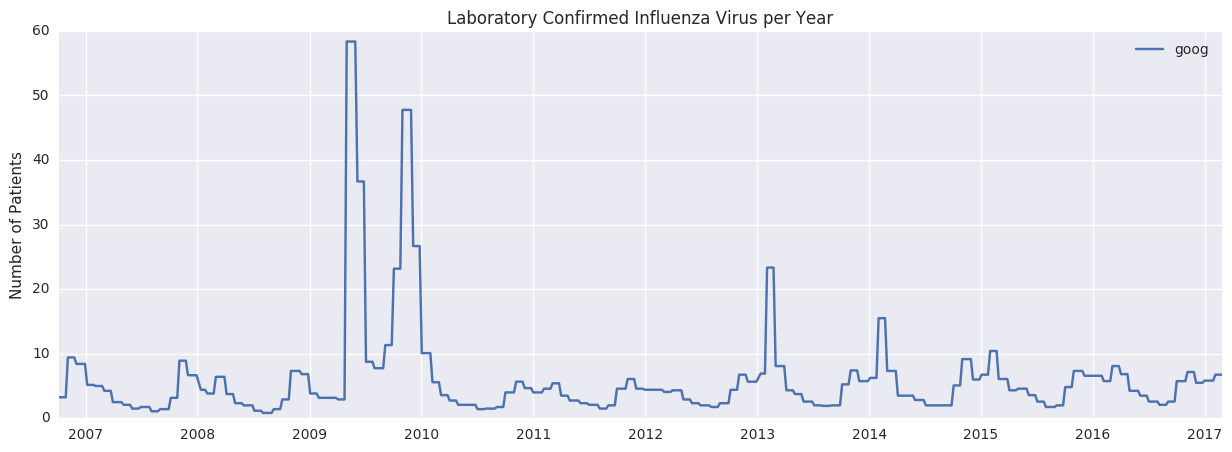

In [6]:
plt.figure(figsize=(15,5))
plt.ylabel('Number of Patients')
plt.title('Laboratory Confirmed Influenza Virus per Year')
x = plt.plot(df.index, df['goog'])
plt.legend(['goog'])
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

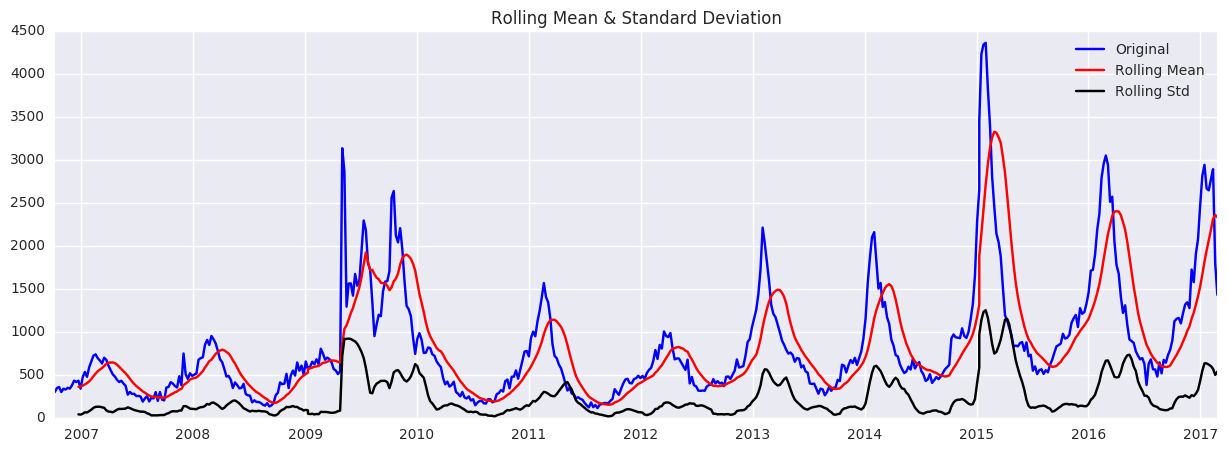

Results of Dickey-Fuller Test:
Test Statistic                  -4.275769
p-value                          0.000489
#Lags Used                      11.000000
Number of Observations Used    535.000000
Critical Value (5%)             -2.866957
Critical Value (1%)             -3.442632
Critical Value (10%)            -2.569655
dtype: float64


In [8]:
plt.figure(figsize=(15,5))
test_stationarity(df['total_specimens'])

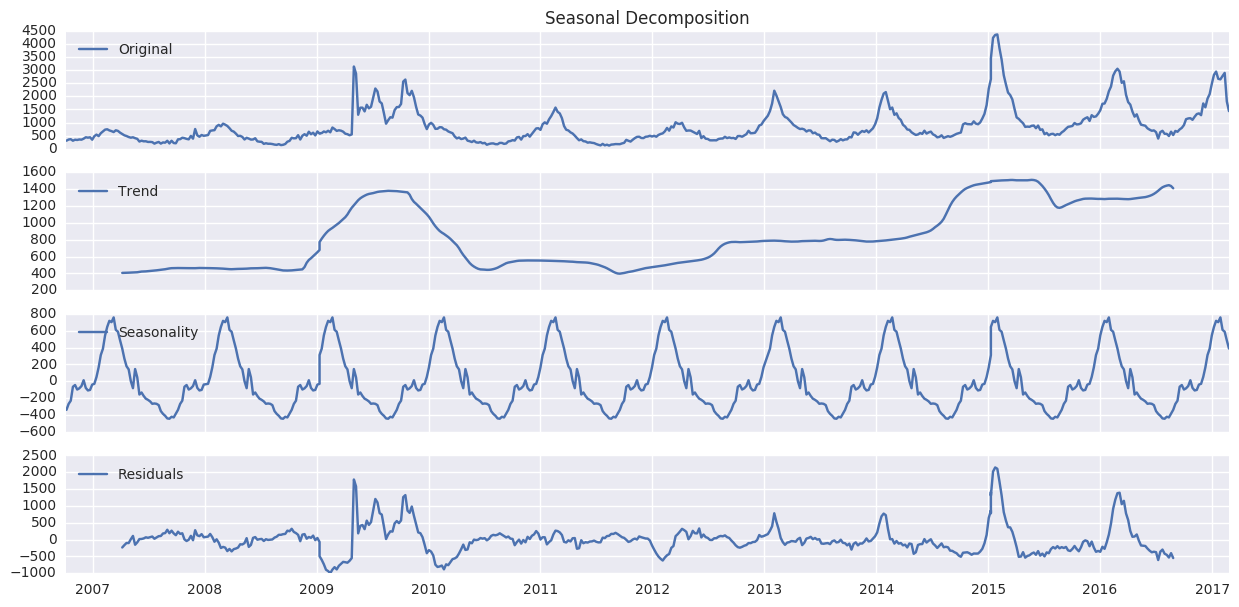

In [9]:
decomposition = seasonal_decompose(df['total_specimens'], freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,7))

ax1.plot(df['total_specimens'], label='Original')
ax2.plot(trend, label='Trend')
ax3.plot(seasonal, label='Seasonality')
ax4.plot(residual, label='Residuals')

ax1.set_title('Seasonal Decomposition')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
plt.show()

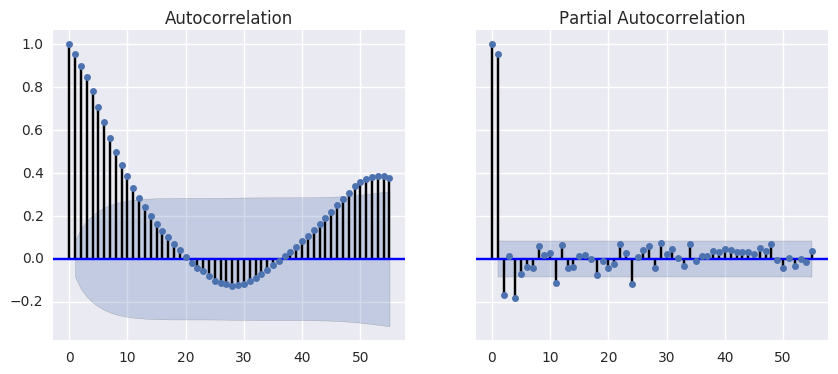

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
plot_acf(df['total_specimens'], lags=55, ax=ax1)
plot_pacf(df['total_specimens'], lags=55, ax=ax2)
plt.show()

Specification to allow for an additive seasonal effect

In [11]:
ar = 1 #this is the maximum degree specification
ma = (0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1) # this is the lag polynomial specification

In [12]:
diff = sm.tsa.statespace.SARIMAX(df['total_specimens'].values, freq='W', order=(ar,1,ma))
diff_res = diff.fit(disp=False)
print(diff_res.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  547
Model:             SARIMAX(1, 1, (2, 4, 11, 23))   Log Likelihood               -3661.179
Date:                           Sun, 12 Mar 2017   AIC                           7334.358
Time:                                   23:07:58   BIC                           7360.184
Sample:                                        0   HQIC                          7344.453
                                           - 547                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1690      0.019      8.932      0.000       0.132       0.206
ma.L2         -0.0730      0.012     -6.307

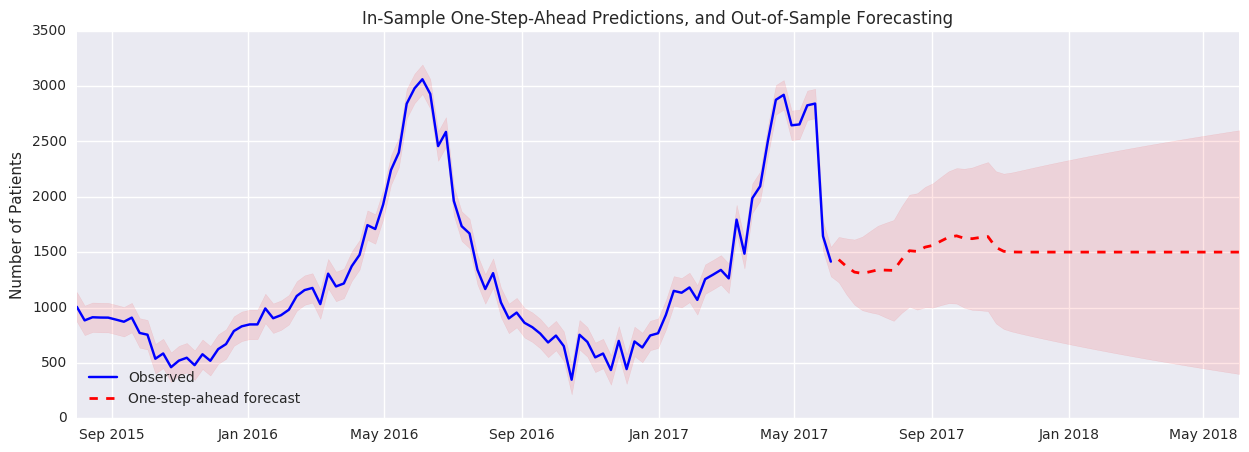

In [13]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 52
predict = diff_res.get_prediction(start=451, end=diff.nobs + nforecast)
idx = pd.date_range('2015-08', periods=149, freq='W-SAT')
predict_ci = predict.conf_int(alpha=0.5).values

# Graph
fig, ax = plt.subplots(figsize=(15,5))
npre = 4
ax.set(title='In-Sample One-Step-Ahead Predictions, and Out-of-Sample Forecasting', ylabel='Number of Patients')

# Plot data points
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'b-', label='Observed')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='One-step-ahead forecast')
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], color='r', alpha=0.1)


legend = ax.legend(loc='lower left')

In [14]:
# Variables
endog = df.ix['2015-08':, 'total_specimens']
exog = sm.add_constant(df.ix['2015-08':, 'ilitotal'])
nobs = endog.shape[0]

In [15]:
# Fit the model with exogenous data
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,1,4))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:        total_specimens   No. Observations:                   83
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -524.472
Date:                Sun, 12 Mar 2017   AIC                           1064.943
Time:                        23:07:59   BIC                           1084.294
Sample:                    08-01-2015   HQIC                          1072.717
                         - 02-25-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068   2.29e+04  -2.98e-07      1.000   -4.48e+04    4.48e+04
ilitotal       0.6234      0.078      7.965      0.000       0.470       0.777
ar.L1         -0.7157      0.153     -4.689      0.0

In [16]:
full_mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,1,4))
full_res = full_mod.filter(res.params)

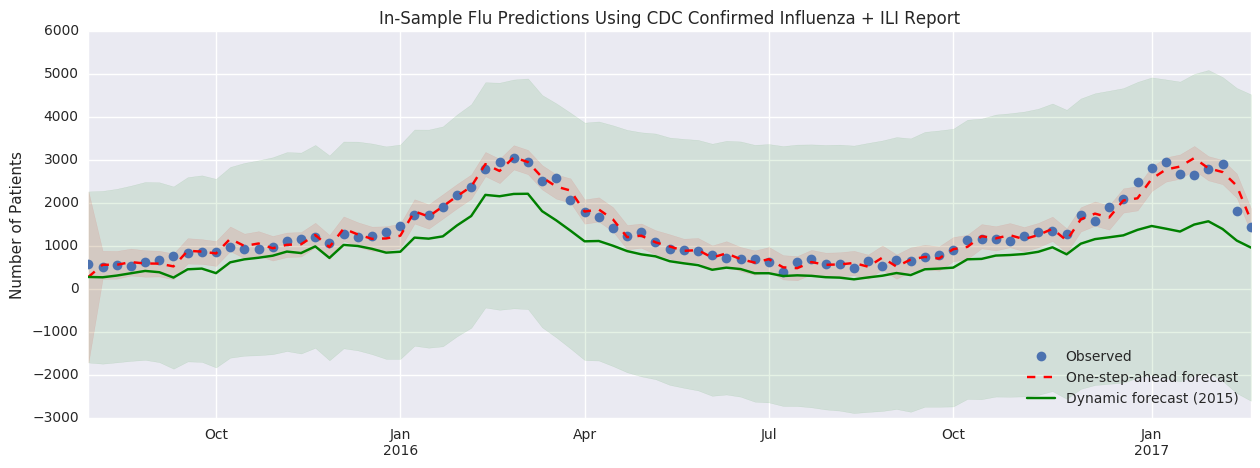

In [17]:
# In-sample one-step-ahead predictions
predict = full_res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
predict_dy = full_res.get_prediction(dynamic='2015-08')
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(15,5))
npre = 4
ax.set(title='In-Sample Flu Predictions Using CDC Confirmed Influenza + ILI Report', ylabel='Number of Patients')

# Plot data points
df.ix['2015-08':, 'total_specimens'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.ix['2015-08':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.ix['2015-08':]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.ix['2015-08':].plot(ax=ax, style='g', label='Dynamic forecast (2015)')
ci = predict_dy_ci.ix['2015-08':]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

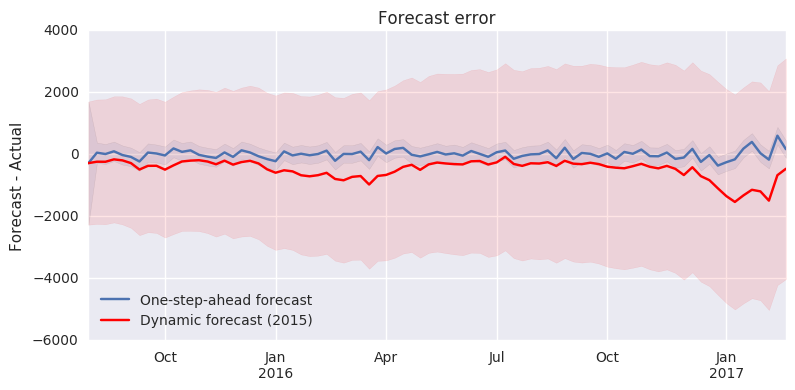

In [18]:
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Forecast error', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - endog
predict_error.ix['2015-08':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.ix['2015-08':].copy()
ci.iloc[:,0] -= endog.loc['2015-08':]
ci.iloc[:,1] -= endog.loc['2015-08':]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - endog
predict_dy_error.ix['2015-08':].plot(ax=ax, style='r', label='Dynamic forecast (2015)')
ci = predict_dy_ci.ix['2015-08':].copy()
ci.iloc[:,0] -= endog.loc['2015-08':]
ci.iloc[:,1] -= endog.loc['2015-08':]
ax.fill_between(ci.index, ci.ix[:,0], ci.ix[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

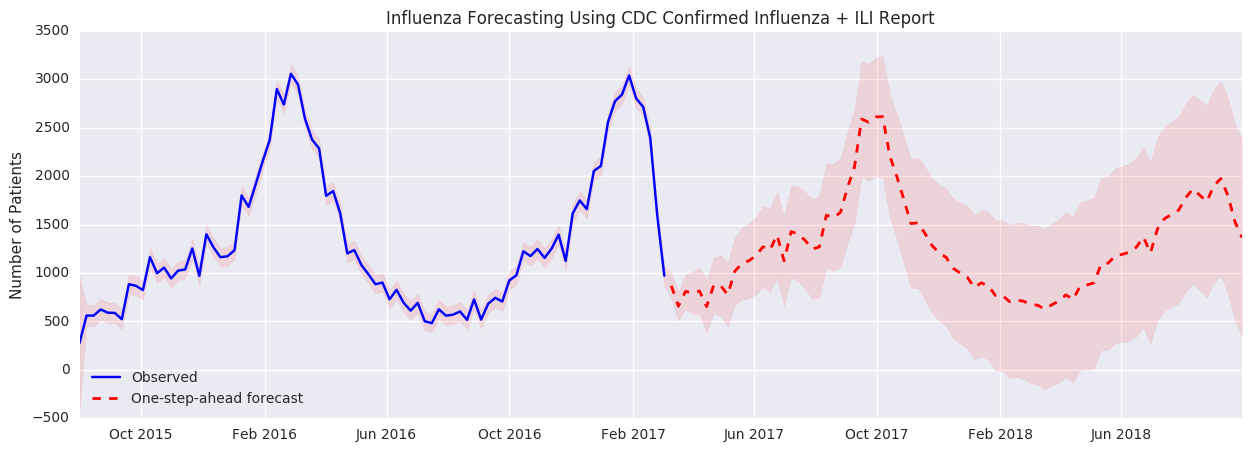

In [19]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 82
predict = res.get_prediction(end=mod.nobs + nforecast, exog=exog)
idx = pd.date_range('2015-08', periods=166, freq='W-SAT')
predict_ci = predict.conf_int(alpha=0.5).values

# Graph
fig, ax = plt.subplots(figsize=(15,5))
npre = 4
ax.set(title='Influenza Forecasting Using CDC Confirmed Influenza + ILI Report', ylabel='Number of Patients')

# Plot data points
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'b-', label='Observed')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='One-step-ahead forecast')
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], color='r', alpha=0.1)


legend = ax.legend(loc='lower left')